
   # Autoencoders

## Overview

이번 실습은 autoencoder를 설계하고, 실제로 학습해보는 실습입니다.

시작하기에 앞서, 실습에 필요한 packages를 import 하겠습니다.

In [1]:
import torch
import torch.nn as nn
import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

DEVICE = torch.device("cuda")

## Fashion MNIST 데이터셋 로드

Fashion MNIST 데이터셋은 28x28 크기의 그레이 스케일 이미지로 구성된 데이터셋입니다.  
총 10개의 클래스를 합쳐 60,000개의 train set, 10,000개의 test set으로 구성되어있습니다.  
이번 실습은 Fashion MNIST 이미지 데이터를 latent vector로 압축하는 encoder와, 다시 이미지로 복구하는 decoder를 구현해보는 실습입니다.  

실습에 앞서 필요한 데이터를 로드하도록 하겠습니다.
아래 코드는 Fashion MNIST 데이터를 로드하는 코드입니다.

In [2]:
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

dataset_path = './datasets'
batch_size = 100
test_batch_size = 1000

fashionmnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = FashionMNIST(dataset_path, transform=fashionmnist_transform, train=True, download=True)
test_dataset  = FashionMNIST(dataset_path, transform=fashionmnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=test_batch_size, shuffle=False, **kwargs)

100%|██████████| 26421880/26421880 [00:15<00:00, 1681101.33it/s]


Extracting ./datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./datasets/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 109983.39it/s]


Extracting ./datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:09<00:00, 457970.45it/s] 


Extracting ./datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5050825.03it/s]

Extracting ./datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/FashionMNIST/raw



In [3]:
image, label = train_dataset[0]

In [4]:
image.shape, label

(torch.Size([1, 28, 28]), 9)

## Basic autoencoder

다음 코드는 Fashion MNIST 데이터를 압축/복원하는 auto encoder 코드입니다.

### Implementation: auto encoder 구현
* input / latent / output  
  * input shape: batch x 28 x 28  
  * latent shape: batch x 64  
  * output shape: batch x 28 x 28  
* call  
  * input $x$ → latent $z$ → output $\hat{x}$

Example:
* Encoder  
  reshape: [batch, 1, 28, 28] → [batch, 784]  
  fc: [batch, 784] → [batch, latent_dim(64)]  

* Decoder  
  fc: [batch, latent_dim(64)] → [batch, 784]  
  reshape: [batch, 784] → [batch, 1, 28, 28] \\
  sigmoid: value_range: (-∞,∞) → (0, 1)    



In [5]:
input_dim = 784
height = 28
width = 28
channel = 1

class AutoEncoder(nn.Module):
  def __init__(self, latent_dim=64):
    super().__init__()

    ############### ToDo ###############
    self.encoder = nn.Sequential(
      nn.Linear(input_dim, latent_dim),
    )

    self.decoder = nn.Sequential(
      nn.Linear(latent_dim, input_dim),
      nn.Sigmoid()
    )
    #####################################

  def encode(self, x):
    x = x.reshape((-1, input_dim))
    z = self.encoder(x)
    return z

  def decode(self, z):
    x_hat = self.decoder(z)
    x_hat = x_hat.reshape((-1, channel, height, width))
    return x_hat

  def forward(self, x):
    z = self.encode(x)
    x_hat = self.decode(z)
    return x_hat, z

In [6]:
latent_dim = 64
model = AutoEncoder(latent_dim).to(DEVICE)

In [7]:
all_labels = [label for _, label in train_dataset]

In [8]:
np.unique(all_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

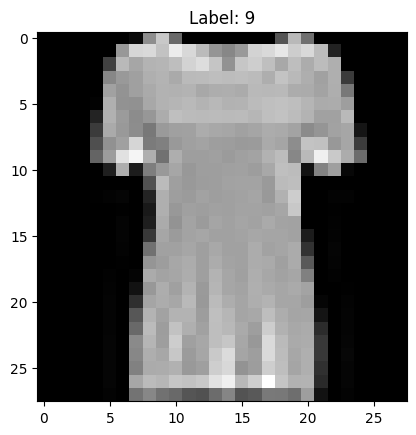

In [9]:
import matplotlib.pyplot as plt

image, _ = train_dataset[10]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f'Label: {label}')
plt.show()

다음 코드는 auto encoder를 학습하기 위한 코드입니다.

In [10]:
from torch.optim import Adam

lr = 1e-2
optimizer = Adam(model.parameters(), lr=lr)

In [11]:
epochs = 10

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, z = model(x)
        ############### ToDo ###############
        loss = nn.MSELoss()(x_hat, x)
        ####################################

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

	Epoch 1 complete! 	Average Loss:  0.0001890206841350796
	Epoch 2 complete! 	Average Loss:  9.993790034733351e-05
	Epoch 3 complete! 	Average Loss:  9.585445997101536e-05
	Epoch 4 complete! 	Average Loss:  9.595042522934472e-05
	Epoch 5 complete! 	Average Loss:  9.566800183739408e-05
	Epoch 6 complete! 	Average Loss:  9.532450157247222e-05
	Epoch 7 complete! 	Average Loss:  9.581590202700763e-05
	Epoch 8 complete! 	Average Loss:  9.664349379997471e-05
	Epoch 9 complete! 	Average Loss:  9.57719205360928e-05
	Epoch 10 complete! 	Average Loss:  9.583863107882478e-05
Finish!!


아래 코드는 학습된 auto encoder 모델로 reconstruction을 진행하는 코드입니다.

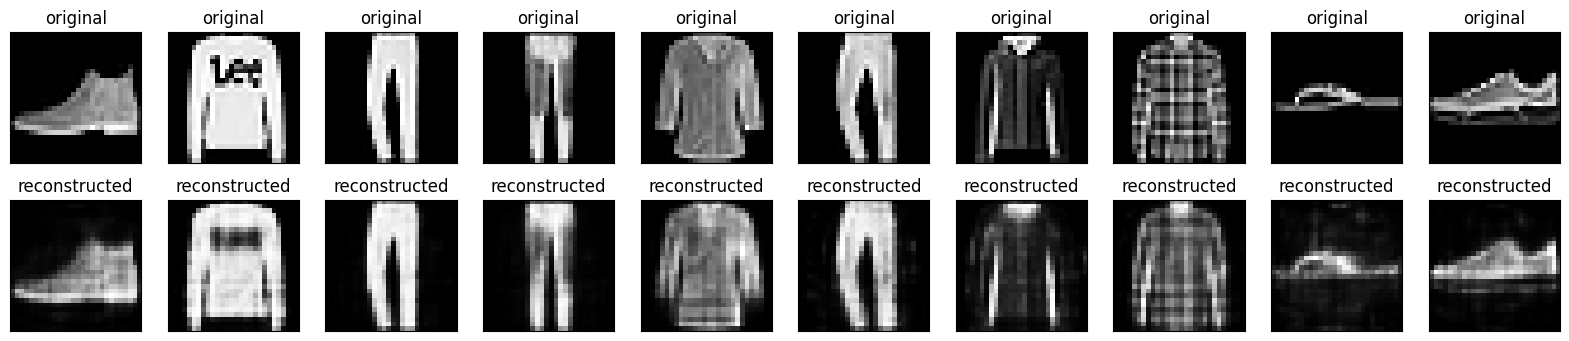

In [12]:
with torch.no_grad():
    x_test, y_test = next(iter(test_loader))
    x_hat_test, z_test = model(x_test.to(DEVICE)) # decoder output, encoder output
    x_hat_test = x_hat_test.cpu()
    z_test = z_test.cpu()

n = 10
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i].permute(1, 2, 0))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(x_hat_test[i].permute(1, 2, 0))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [13]:
x_hat_test.shape, z_test.shape

(torch.Size([1000, 1, 28, 28]), torch.Size([1000, 64]))

In [14]:
print(z_test[0])

tensor([-6.5150,  0.7803, -0.7797,  1.1056,  0.4945,  1.0391,  0.5459, -0.0878,
         1.0781,  0.6661,  0.5307,  0.9395, -0.5079, -1.2769,  0.3076,  1.2927,
        -1.0603, -1.0577,  0.8173,  0.5973,  0.2552, -0.9414,  0.9537, -1.5283,
        -0.4302,  0.4565, -0.0739,  1.2075,  0.5860,  2.3444, -2.0009,  0.7922,
        -0.7969, -1.0748,  0.8260,  0.2651,  0.0208, -1.2202, -0.4012,  0.0211,
         0.7702, -0.5318,  1.1415, -1.7308, -1.6414,  2.1436, -0.4833,  0.3177,
        -0.6649,  1.4804, -0.6532,  0.2349, -1.9503,  0.3774,  0.2737, -1.2155,
         1.8625, -0.0561, -0.4722, -1.0047,  1.4232,  2.7401, -0.8812, -0.0176])


# T-SNE

고차원의 복잡한 데이터들을 직관적으로 이해하기 어렵기 때문에, 일반적으로 낮은 차원으로 변환하여 시각화를 하여 분석을 하게 됩니다.  
t-SNE(t-Distributed Stochastic Neighbor Embedding)는 대표적인 차원 축소(dimensionality reduction) 기법입니다.  
아래 코드는 t-SNE를 이용하여 auto encoder로 얻어낸 embedding들을 시각화하는 코드입니다.

In [15]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

def plot_tsne(inputs, labels):
  n_samples = len(labels)
  tsne = TSNE(n_components=2, perplexity=10, n_iter=300)
  tsne_features = tsne.fit_transform(inputs[:n_samples].reshape(n_samples, -1))
  df = pd.DataFrame({
      'x': tsne_features[:,0],
      'y': tsne_features[:,1],
      'label': labels[:n_samples]
  })

  sns.scatterplot(data=df, x='x', y='y', hue='label', palette="deep")

def plot(inputs, labels):
  n_samples = len(labels)

  df = pd.DataFrame({
      'x': inputs[:,0],
      'y': inputs[:,1],
      'label': labels[:n_samples]
  })

  sns.scatterplot(data=df, x='x', y='y', hue='label', palette="deep")

In [16]:
y_test.shape, z_test.shape

(torch.Size([1000]), torch.Size([1000, 64]))

/home/devrok/.conda/envs/nlp_pt/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


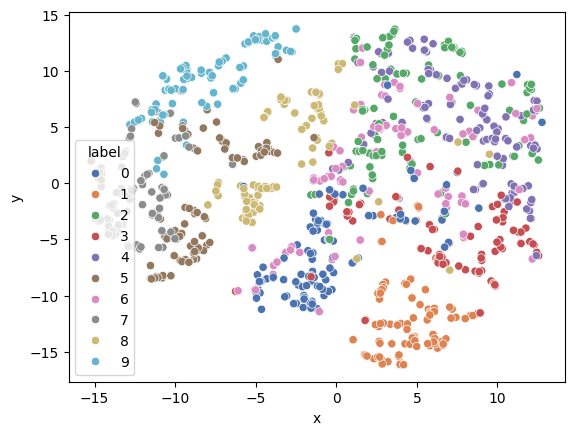

In [17]:
plot_tsne(z_test, y_test)

/home/devrok/.conda/envs/nlp_pt/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


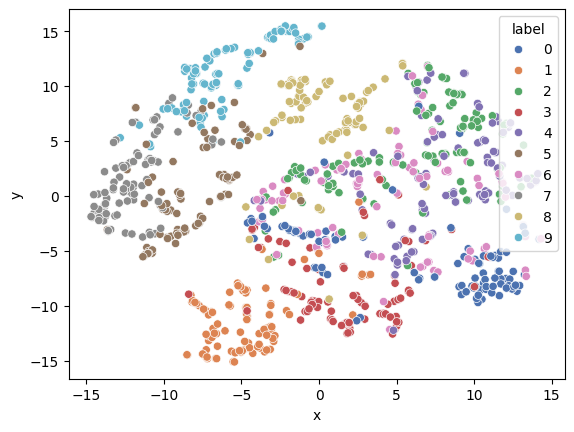

In [18]:
plot_tsne(x_test, y_test)

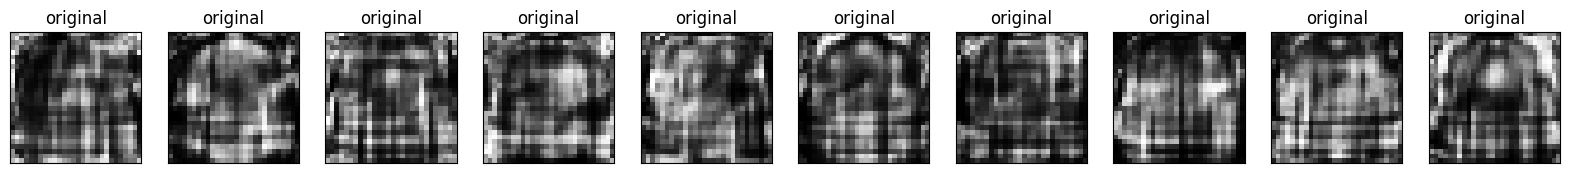

In [19]:
with torch.no_grad():
    z_random = torch.randn(test_batch_size, latent_dim).to(DEVICE)
    x_hat_gen = model.decode(z_random)
    x_hat_gen = x_hat_gen.cpu()


n = 10
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4))
for i in range(n):
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_hat_gen[i].permute(1, 2, 0))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)